# **Oil Spill Detection: Classification with Imbalanced Data**

This notebook tackles the binary classification problem of detecting oil spills from radar image features. The dataset is heavily imbalanced, with only 4.4% of the samples belonging to the positive class (oil spill). The main goal is to explore various modeling strategies that deal with this imbalance.

The pipeline includes:
- Basic data cleaning and partitioning
- Data preprocessing for numerical variables
- Evaluation of baseline and advanced classification models
- Comparison of regular and class-weighted logistic models
- Hyperparameter tuning with resampling (SMOTETomek)
- Final evaluation on a hold-out test set

Performance is assessed using **G-mean** as the primary metric, supported by ROC and Precision-Recall curves and confusion matrix analysis.

> Due to the dataset's small size and severe imbalance, learning reliable patterns for the positive class proves especially challenging.


#Data Loading and Preprocessing


In [56]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import ConfusionMatrixDisplay

# Load dataset
path = 'oil_spill.csv'
df = pd.read_csv(path, header=None)

print('DataFrame shape:', df.shape)

# Drop non-informative columns
df.drop([0, 22], axis=1, inplace=True)

# Rename columns to integers
df.columns = list(range(df.shape[1]))

# Split features and target
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Stratified data split: Train, Validation, Test
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)

print('\nClass Distribution:')
print(f'Train: Positive class count = {ytrain.sum()}, Percentage = {100 * ytrain.mean():.2f}%')
print(f'Validation: Positive class count = {yval.sum()}, Percentage = {100 * yval.mean():.2f}%')
print(f'Test: Positive class count = {ytest.sum()}, Percentage = {100 * ytest.mean():.2f}%')


DataFrame shape: (937, 50)

Class Distribution:
Train: Positive class count = 29, Percentage = 4.40%
Validation: Positive class count = 7, Percentage = 4.24%
Test: Positive class count = 5, Percentage = 4.42%


**Observation**

The target variable is highly imbalanced. This should be considered during model evaluation using metrics such as G-mean, ROC AUC, and precision-recall curves.

#Exploratory Data Analysis

In [57]:
# Summary statistics of training features
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


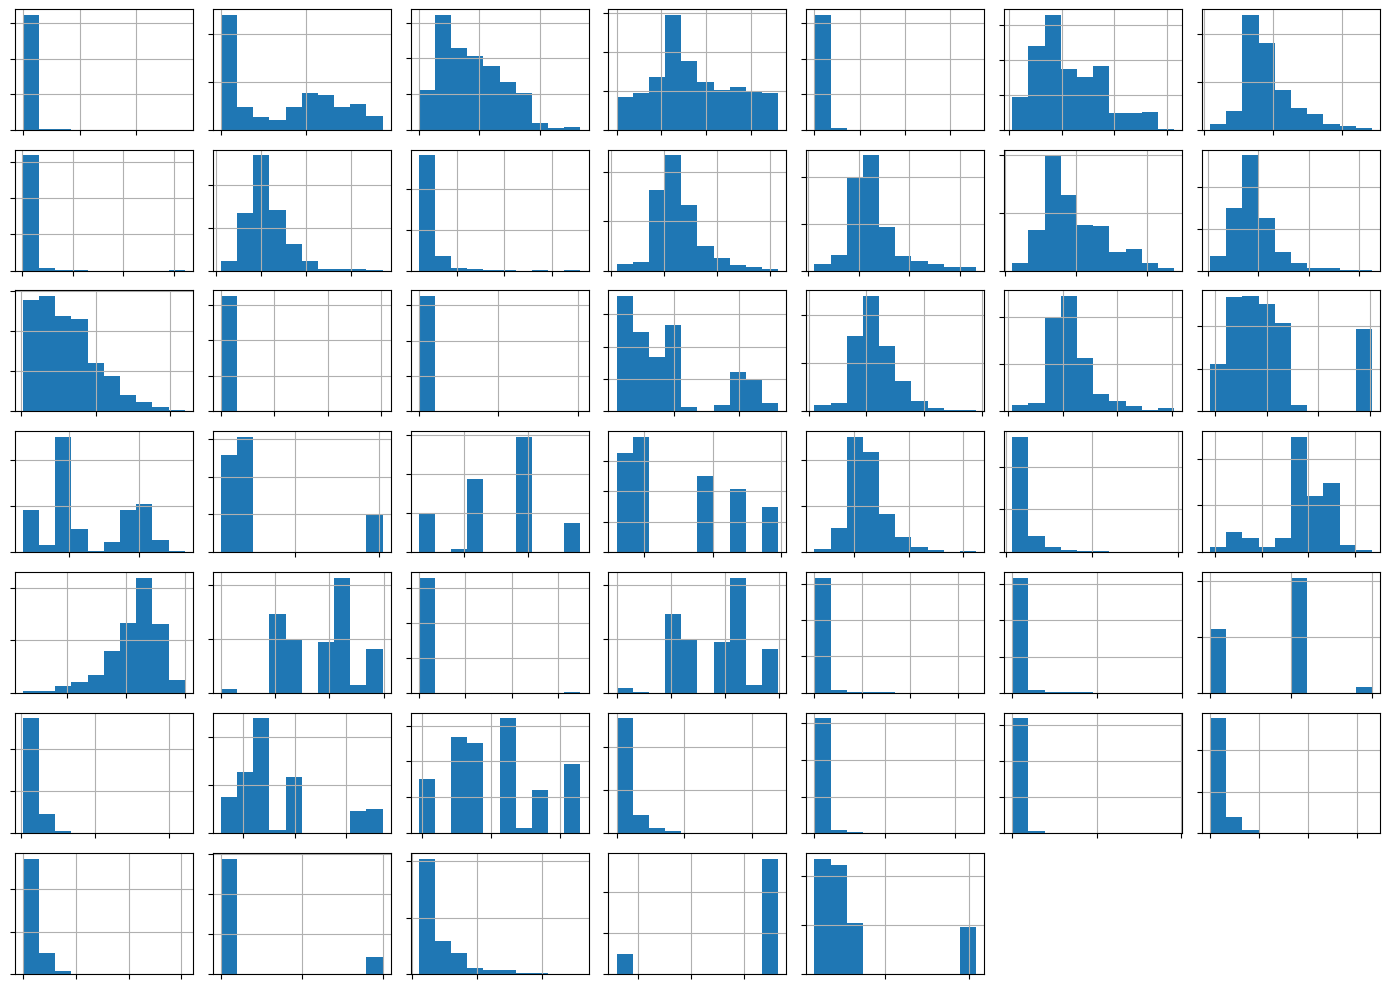

In [58]:
# Histograms of feature distributions
axes = Xtrain.hist(figsize=(14, 10))
for ax in axes.flatten():
    ax.set_title('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.tight_layout()
plt.show()


In [59]:
# Data types and non-null counts
Xtrain.info()


<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

**Observation:**

Most features are numerical and seem to have varying ranges and distributions. This justifies standardization before training.

#Baseline Model Evaluation

In [60]:
def evaluate_model(X, y, model):
    """
    Evaluate a classification model using repeated stratified k-fold cross-validation
    and geometric mean as the scoring metric.

    Args:
        X (DataFrame): Feature matrix
        y (Series): Target vector
        model: Scikit-learn compatible classifier

    Returns:
        ndarray: Array of G-mean scores
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(geometric_mean_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# Baseline dummy classifier
dummy_model = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, dummy_model)

print(f'G-mean score: {mean(scores):.3f} (±{std(scores):.3f})')


G-mean score: 0.399 (±0.210)


**Observation:**

The dummy classifier provides a baseline for comparison. Due to the imbalance, the G-mean score is expected to be low, reflecting poor classification of the minority class.

#Preprocessing and Metric Definition

In [61]:
# Numerical transformation pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Apply transformation to all columns (they are all numerical in this dataset)
column_transformer = ColumnTransformer(
    transformers=[('num', numeric_pipeline, Xtrain.columns)],
    remainder='passthrough'
)

# G-mean scorer
gmean_scorer = make_scorer(geometric_mean_score)


**Observation:**

All features are numeric, so the transformer is applied to every column. G-mean is used as a robust metric for imbalanced classification tasks.

#Model Training and Evaluation (Logistic Regression Variants & kNN)

Validation Results:

LR
Accuracy: 0.951 (0.015)
G-mean: 0.753 (0.079)

LASSO
Accuracy: 0.968 (0.009)
G-mean: 0.689 (0.104)

RIDGE
Accuracy: 0.969 (0.011)
G-mean: 0.725 (0.108)

EN
Accuracy: 0.968 (0.010)
G-mean: 0.694 (0.112)

kNN
Accuracy: 0.966 (0.005)
G-mean: 0.464 (0.204)



/tmp/ipython-input-62-690464384.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracy_results, labels=names, showmeans=True)


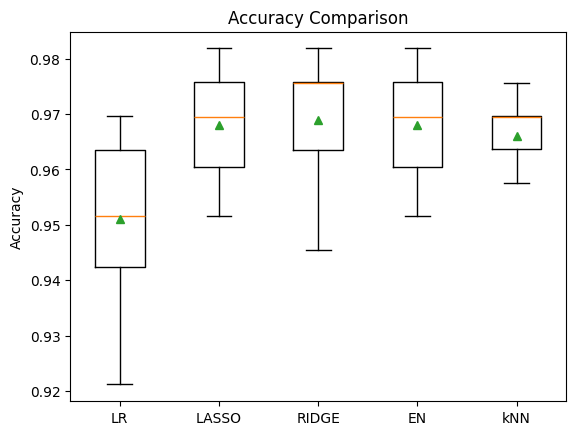

/tmp/ipython-input-62-690464384.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(gmean_results, labels=names, showmeans=True)


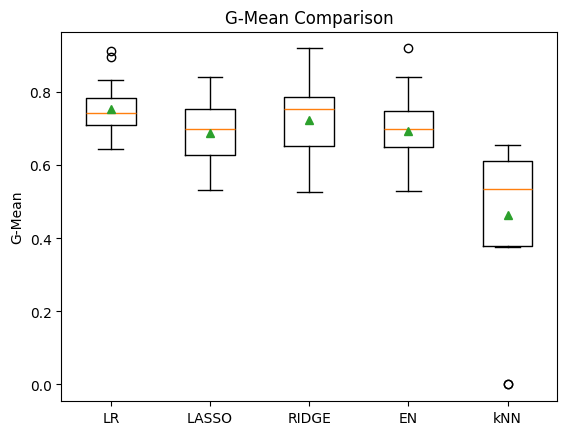

In [62]:
def get_models():
    """
    Define a set of classification models:
    - Logistic Regression (no penalty, L1, L2, Elastic Net)
    - k-Nearest Neighbors

    Returns:
        tuple: (list of models, list of model names)
    """
    models = []
    names = []

    models.append(LogisticRegression(penalty=None, max_iter=2000, random_state=1))
    names.append('LR')

    models.append(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=1))
    names.append('LASSO')

    models.append(LogisticRegression(penalty='l2', max_iter=2000, random_state=1))
    names.append('RIDGE')

    models.append(LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=5000, random_state=1))
    names.append('EN')

    models.append(KNeighborsClassifier(n_neighbors=5))
    names.append('kNN')

    return models, names

# Train and evaluate models
models, names = get_models()
accuracy_results = []
gmean_results = []

print('Validation Results:\n')

for i, model in enumerate(models):
    pipeline = Pipeline(steps=[
        ('preprocessing', column_transformer),
        ('classifier', model)
    ])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_validate(
        pipeline,
        Xtv,
        np.ravel(ytv),
        scoring={'accuracy': 'accuracy', 'gmean': gmean_scorer},
        cv=cv
    )

    accuracy_results.append(scores['test_accuracy'])
    gmean_results.append(scores['test_gmean'])

    print(f"{names[i]}")
    print(f"Accuracy: {np.nanmean(scores['test_accuracy']):.3f} ({np.nanstd(scores['test_accuracy']):.3f})")
    print(f"G-mean: {np.nanmean(scores['test_gmean']):.3f} ({np.nanstd(scores['test_gmean']):.3f})\n")

# Plot accuracy
plt.boxplot(accuracy_results, labels=names, showmeans=True)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Plot G-mean
plt.boxplot(gmean_results, labels=names, showmeans=True)
plt.title("G-Mean Comparison")
plt.ylabel("G-Mean")
plt.show()


**Observation:**

This block compares various models under two metrics: accuracy and G-mean. G-mean is critical due to the dataset’s class imbalance. Boxplots help visualize model stability across folds.

# Evaluation with Class Weight Balancing (No Sampling)

Validation Results (Balanced Models):

LR
G-Mean: 0.692 (0.117)

LASSO
G-Mean: 0.849 (0.069)

RIDGE
G-Mean: 0.852 (0.070)

EN
G-Mean: 0.851 (0.070)

kNN
G-Mean: 0.464 (0.204)



/tmp/ipython-input-63-2808606961.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(gmean_results, labels=names_balanced, showmeans=True)


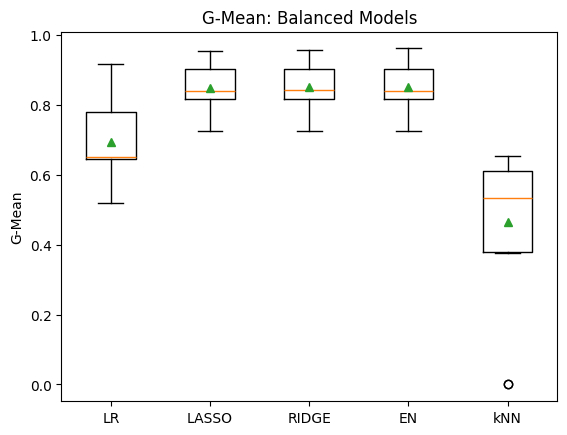

In [63]:
def define_balanced_models():
    """
    Returns a list of classification models using balanced class weights,
    and their corresponding names.

    Returns:
        models (list): List of scikit-learn model instances.
        names (list): List of model names as strings.
    """
    models, names = [], []

    models.append(LogisticRegression(penalty=None, max_iter=2000, class_weight='balanced', random_state=1))
    names.append('LR')

    models.append(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, class_weight='balanced', random_state=1))
    names.append('LASSO')

    models.append(LogisticRegression(penalty='l2', max_iter=2000, class_weight='balanced', random_state=1))
    names.append('RIDGE')

    models.append(LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=5000, class_weight='balanced', random_state=1))
    names.append('EN')

    models.append(KNeighborsClassifier(n_neighbors=5))
    names.append('kNN')

    return models, names


# Train and evaluate models with class_weight='balanced'
models_balanced, names_balanced = define_balanced_models()
gmean_results = []

print('Validation Results (Balanced Models):\n')

for model, name in zip(models_balanced, names_balanced):
    pipeline = Pipeline(steps=[
        ('preprocessing', column_transformer),
        ('classifier', model)
    ])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

    scores = cross_validate(
        pipeline,
        Xtv,
        np.ravel(ytv),
        scoring={'gmean': gmean_scorer},
        cv=cv
    )

    gmean_results.append(scores['test_gmean'])

    print(f"{name}")
    print(f"G-Mean: {np.nanmean(scores['test_gmean']):.3f} ({np.nanstd(scores['test_gmean']):.3f})\n")


# Boxplot for visual comparison
plt.boxplot(gmean_results, labels=names_balanced, showmeans=True)
plt.title("G-Mean: Balanced Models")
plt.ylabel("G-Mean")
plt.show()



**Observation:**

This section tests the impact of using class_weight='balanced' on logistic regression and kNN classifiers to mitigate class imbalance. Although it avoids sampling methods, results can still be suboptimal if the feature space is not sufficiently discriminative.

#Hyperparameter Tuning with SMOTETomek

In [64]:
best_base_model = models[1]  # Logistic Regression with L1

param_grid = {
    'classifier__C': [0.007, 0.008, 0.009],
    'classifier__penalty': ['l1', 'l2'],
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

pipeline = ImbPipeline(steps=[
    ('preprocessing', column_transformer),
    ('sampling', SMOTETomek(random_state=1)),
    ('classifier', best_base_model)
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=gmean_scorer,
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

grid_result = grid.fit(Xtv, np.ravel(ytv))

print("Best model G-mean: %.4f with params: %s" % (grid_result.best_score_, grid_result.best_params_))
print('Train score mean(std): %.4f(%.4f)' % (
    np.nanmean(grid_result.cv_results_['mean_train_score']),
    np.nanmean(grid_result.cv_results_['std_train_score'])
))
print('Validation score mean(std): %.4f(%.4f)' % (
    np.nanmean(grid_result.cv_results_['mean_test_score']),
    np.nanmean(grid_result.cv_results_['std_test_score'])
))


Best model G-mean: 0.8760 with params: {'classifier__C': 0.009, 'classifier__penalty': 'l2'}
Train score mean(std): 0.8733(0.0153)
Validation score mean(std): 0.8501(0.0599)


 **Hyperparameter Tuning with SMOTETomek**

Initial values of the regularization parameter `C` (0.06 to 0.9) showed significant overfitting.  
To address class imbalance, we incorporated the **SMOTETomek** resampling strategy.

Using a `GridSearchCV`, we tuned the `C` and `penalty` parameters of a Logistic Regression model.  
The best configuration found was:

- **G-Mean:** 0.8760  
- **Parameters:** `C=0.009`, `penalty='l2'`  
- **Train Score:** 0.8733 ± 0.0153  
- **Validation Score:** 0.8501 ± 0.0599

This configuration achieves a good trade-off between class balance and generalization.


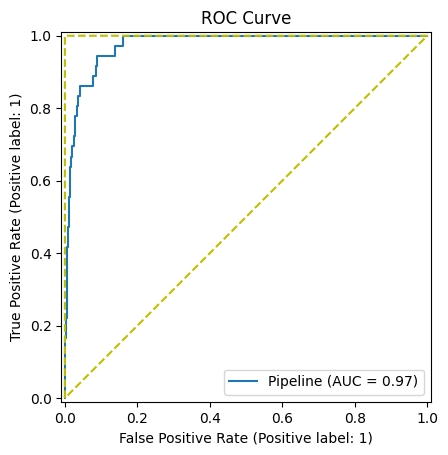

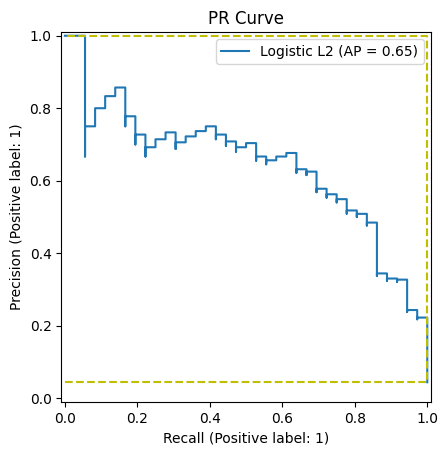

In [65]:
best_model = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    max_iter=3000,
    class_weight='balanced',
    C=0.009,
    random_state=8
)

pipeline = ImbPipeline(steps=[
    ('preprocessing', column_transformer),
    ('sampling', SMOTETomek(random_state=1)),
    ('classifier', best_model)
])

pipeline.fit(Xtv, np.ravel(ytv))

RocCurveDisplay.from_estimator(pipeline, Xtv, ytv)
plt.plot([0, 0, 1, 0], [0, 1, 1, 0], 'y--')
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(pipeline, Xtv, ytv, name="Logistic L2")
plt.plot([0, 1, 1, 0], [0.044, 0.044, 1, 1], 'y--')
plt.legend(loc="upper right")
plt.title("PR Curve")
plt.show()


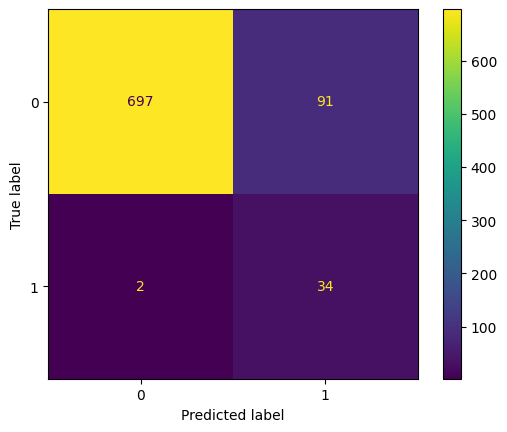

In [66]:
ConfusionMatrixDisplay.from_estimator(pipeline, Xtv, ytv)
plt.show()


**ROC Curve**  
The area under the curve is 0.97. However, due to class imbalance, this metric can be misleading by overstating model performance.

**PR Curve**  
The AUC is 0.65, providing a more realistic assessment. Since this curve focuses on the positive class, it highlights the model's limited ability to predict minority instances.


# **Ejercicio-5**

G-Mean on Test Set: 0.5963


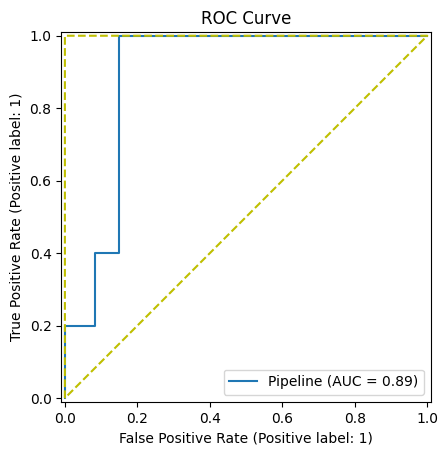

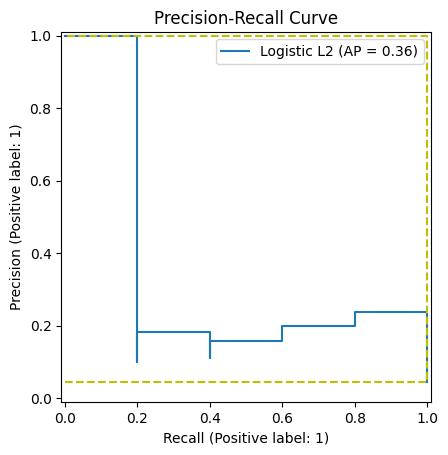

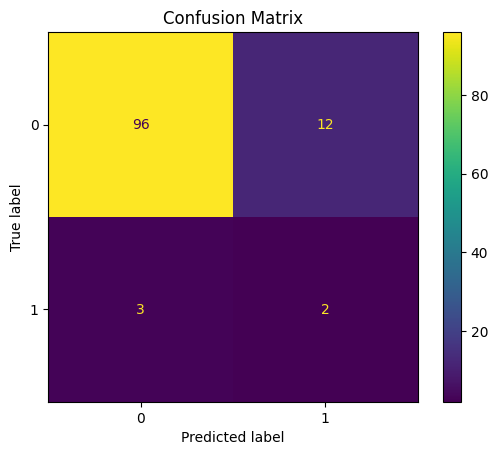

In [67]:
# Predict on test set
y_pred = pipeline.predict(Xtest)
gmean_test = geometric_mean_score(ytest, y_pred)

print(f"G-Mean on Test Set: {gmean_test:.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(pipeline, Xtest, ytest)
plt.plot([0, 0, 1, 0], [0, 1, 1, 0], 'y--')  # Reference triangle
plt.title("ROC Curve")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(pipeline, Xtest, ytest, name="Logistic L2")
plt.plot([0, 1, 1, 0], [0.044, 0.044, 1, 1], 'y--')  # Reference
plt.legend(loc="upper right")
plt.title("Precision-Recall Curve")
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(pipeline, Xtest, ytest)
plt.title("Confusion Matrix")
plt.show()


#Final Conclusion
The final model achieved a G-mean of 0.596, which falls within the variability range of the baseline Dummy model (0.395 to 0.637). This indicates that the classifier does not significantly outperform the baseline.

The Precision-Recall AUC was 0.36, suggesting the model struggles to correctly identify the positive class. This issue is confirmed by the confusion matrix, which shows a high number of false positives.

Throughout the process, the pipeline included:

* Numerical and categorical preprocessing

* Hyperparameter tuning

* Class balancing via SMOTETomek

Despite these efforts, performance remained low. A likely cause is the limited dataset size (only 1,000 instances), combined with a severe class imbalance: only 4.4% of samples belong to the positive class. This results in just 44 positive examples, which hinders the model's ability to learn reliable patterns for minority class detection.